# Imports and define expectation func

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%reload_ext autoreload

In [3]:
from pathlib import Path
import os
cwd_path = Path.cwd(); set_path = str(cwd_path.parent.parent); os.chdir(set_path)

In [4]:
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
from ImportanceSampling.VanillaImportanceSampler import VanillaImportanceSampling
from FittedModels.utils.plotting_utils import plot_distributions, plot_distributions, plot_samples, plot_sampling_info, \
    plot_divergences, plot_history
from FittedModels.train import LearntDistributionManager
from Utils.plotting_utils import plot_func2D, plot_distribution, plot_samples_single_dist
from Utils.numerical_utils import MC_estimate_true_expectation
from Utils.numerical_utils import quadratic_function as expectation_function
from FittedModels.Models.FlowModel import FlowModel
import matplotlib.pyplot as plt
from TargetDistributions.MoG import MoG
from TargetDistributions.MoG import custom_MoG
torch.set_default_dtype(torch.float64)

In [5]:
def plotter(*args, **kwargs):
    # wrap plotting function like this so it displays during training
    plot_samples(*args, **kwargs)
    plt.show()

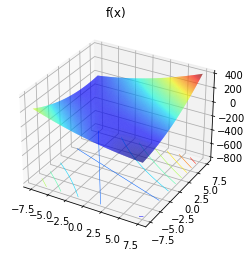

In [6]:
expectation_func_fig = plot_func2D(expectation_function, n_points=200, range=15)

# Lumpy High Dimension Flow Target Distribution

In [7]:
torch.manual_seed(0) 
dim = 4
scaling_factor = 4.0
lr = 1e-4
weight_decay=1e-6
n_flow_steps=64
n_samples_estimation = int(1e6)
epochs = int(2e4)
batch_size = int(1e3)
train_prior=False

In [8]:
target = MoG(dim=dim, n_mixes=10, min_cov=0, loc_scaling=3).to("cuda")
true_expectation = MC_estimate_true_expectation(target, expectation_function, int(1e6))
print(true_expectation)
print(MC_estimate_true_expectation(target, expectation_function, int(1e6))) # print twice to make sure estimates are resonably close

tensor(48.8308, device='cuda:0')
tensor(48.8308, device='cuda:0')


# DReG, alpha=2

In [9]:
torch.manual_seed(1)
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=n_flow_steps, scaling_factor=scaling_factor, flow_type="RealNVP")
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="DReG", lr=lr, 
                                  weight_decay=weight_decay)
expectation_before, info_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

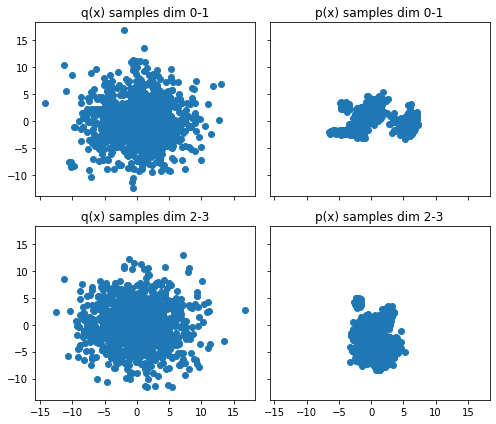

In [10]:
samples_fig_before = plot_samples(tester) # this just looks at 2 dimensions

### If we want to train the prior first

In [11]:
if train_prior:
    history_prior = tester.train_prior(epochs=200, batch_size=batch_size, lr=0.01)
    plot_history(history_prior)
    plot_samples(tester)
    expectation_prior_trained, info_prior = tester.estimate_expectation(n_samples_estimation, expectation_function)

### proper training

loss: -0.10555133086318658, mean log p_x -47.613664192997646:   0%|          | 0/20000 [00:00<?, ?it/s]

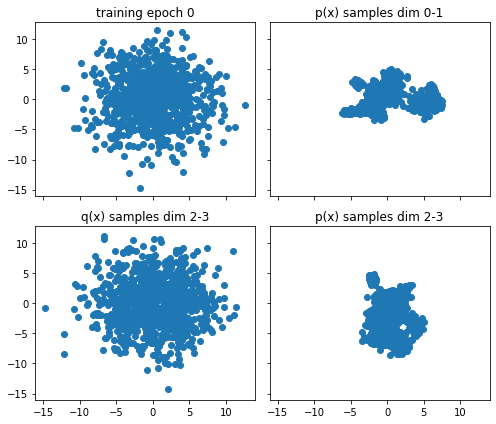

loss: -0.10555133086318658, mean log p_x -47.613664192997646:   0%|          | 14/20000 [00:06<2:17:01,  2.43it/s]

In [ ]:
history = tester.train(epochs, batch_size=batch_size, intermediate_plots=True, plotting_func=plotter) #clip_grad_norm=True, max_grad_norm=1)

In [ ]:
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)

print(f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n"
      f"effective sample size before is {info_before['effective_sample_size'] / n_samples_estimation}\n"
      f"effective sample size after train is {info['effective_sample_size'] / n_samples_estimation}\n"
      f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

if train_prior:
    print(f"estimate after prior training is {expectation_prior_trained} \n"
        f"effective sample size trained prior is {info_prior['effective_sample_size'] / n_samples_estimation}\n")

In [ ]:
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)

print(f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n"
      f"effective sample size before is {info_before['effective_sample_size'] / n_samples_estimation}\n"
      f"effective sample size after train is {info['effective_sample_size'] / n_samples_estimation}\n"
      f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

if train_prior:
    print(f"estimate after prior training is {expectation_prior_trained} \n"
        f"effective sample size trained prior is {info_prior['effective_sample_size'] / n_samples_estimation}\n")

In [ ]:
samples_fig_after = plot_samples(tester)

In [ ]:
plot_divergences(history)

In [ ]:
plot_sampling_info(history)

In [ ]:
plot_history(history)

# KL

In [ ]:
annealing=True

In [ ]:
torch.manual_seed(1)
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=n_flow_steps, scaling_factor=scaling_factor, flow_type="RealNVP")
tester_kl = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="kl", lr=lr, 
                                  weight_decay=1e-6, annealing=annealing)
expectation_before_kl, info_before_kl = tester.estimate_expectation(n_samples_estimation, expectation_function)

In [ ]:
plot_samples(tester_kl)

In [ ]:
history_kl = tester_kl.train(epochs, batch_size=batch_size, intermediate_plots=True)

In [ ]:
expectation_kl, info_kl = tester_kl.estimate_expectation(n_samples_estimation, expectation_function)
print(f"True expectation estimate is {true_expectation} \n"
    f"estimate before training is {expectation_before_kl} \n"
      f"estimate after training is {expectation_kl} \n" 
     f"effective sample size before is {info_before_kl['effective_sample_size']/n_samples_estimation}\n"
     f"effective sample size after train is {info_kl['effective_sample_size']/n_samples_estimation}\n"
     f"variance in weights is {torch.var(info_kl['normalised_sampling_weights'])}")

In [ ]:
expectation_kl, info_kl = tester_kl.estimate_expectation(n_samples_estimation, expectation_function)
print(f"True expectation estimate is {true_expectation} \n"
    f"estimate before training is {expectation_before_kl} \n"
      f"estimate after training is {expectation_kl} \n" 
     f"effective sample size before is {info_before_kl['effective_sample_size']/n_samples_estimation}\n"
     f"effective sample size after train is {info_kl['effective_sample_size']/n_samples_estimation}\n"
     f"variance in weights is {torch.var(info_kl['normalised_sampling_weights'])}")

In [ ]:
samples_fig_after = plot_samples(tester_kl)

In [ ]:
plot_divergences(history_kl)

In [ ]:
plot_sampling_info(history_kl)

In [ ]:
hist_plot = plot_history(history_kl)